In [4]:
import pandas as pd
import manager as m
from openai_textgen import TextGenerator
from datamodel import Goal
from datamodel import Summary, Persona

llm_config = {"n":1, 'max_tokens':2000, "temperature": 0, }
text_gen = TextGenerator()

In [5]:
df = pd.read_excel("../data/ROBERT_KING.xlsx", index_col=0)
nlviz = m.Manager(text_gen=text_gen, data=df)
data_summary = nlviz.summarize(textgen_config=llm_config, summary_method="default")

In [6]:
display(Summary(**data_summary))


## Dataset Summary

---

**Name:** 

**File Name:** 

**Dataset Description:**



**Fields:**

- **Client_Key:** {'column': 'Client_Key', 'properties': {'dtype': 'number', 'std': 0, 'min': 9, 'max': 9, 'samples': [9], 'num_unique_values': 1, 'semantic_type': '', 'description': ''}}
- **Client_Name:** {'column': 'Client_Name', 'properties': {'dtype': 'category', 'samples': ['Robert King'], 'num_unique_values': 1, 'semantic_type': '', 'description': ''}}
- **Date:** {'column': 'Date', 'properties': {'dtype': 'date', 'min': '2023-08-01', 'max': '2023-11-01', 'samples': ['2023-09-10'], 'num_unique_values': 93, 'semantic_type': '', 'description': ''}}
- **Account_Number:** {'column': 'Account_Number', 'properties': {'dtype': 'number', 'std': 0, 'min': 1012345678, 'max': 1012345679, 'samples': [1012345679], 'num_unique_values': 2, 'semantic_type': '', 'description': ''}}
- **Transaction_Type:** {'column': 'Transaction_Type', 'properties': {'dtype': 'category', 'samples': ['ACH'], 'num_unique_values': 6, 'semantic_type': '', 'description': ''}}
- **Transaction_Purpose:** {'column': 'Transaction_Purpose', 'properties': {'dtype': 'category', 'samples': ['Bills & utilities'], 'num_unique_values': 16, 'semantic_type': '', 'description': ''}}
- **Transaction_Amount:** {'column': 'Transaction_Amount', 'properties': {'dtype': 'number', 'std': 67302.40037054197, 'min': -120000.0, 'max': 250000.0, 'samples': [-85.0], 'num_unique_values': 69, 'semantic_type': '', 'description': ''}}
- **Transaction_Description:** {'column': 'Transaction_Description', 'properties': {'dtype': 'string', 'samples': ["POS PURCHASE #2468 BARRY'S BOOTCAMP PACKAGE SF"], 'num_unique_values': 68, 'semantic_type': '', 'description': ''}}


# Suggest questions to ask based on dataset

In [ ]:
display(Summary(**data_summary))

In [ ]:
from datamodel import Persona
persona= Persona(persona="A highly skilled data analyst who can come up with complex, insightful goals about data",rationale="")
goals = nlviz.goals(
        summary=data_summary,
        textgen_config=llm_config,
        n = 3,
        persona=persona)

for g in goals:
    display(g)

In [ ]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[0], textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
print(charts[0].code)

In [ ]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[1], textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
print(charts[0].code)

In [ ]:
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goals[2], textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
print(charts[0].code)

# Generate plots based on user questions

In [ ]:
question = "what is the distribution of transaction purposes ?"
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
question = "What is the break down of total transaction amounts (in thousand dollars) per transaction category?"
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
question = "What is the break down of total transaction amounts (in thousand dollars) per transaction purpose?"
viz_spces = "Avoid labels in the plot and rotate x labels by 90 degrees"
goal = Goal(question=question, visualization=viz_spces, rationale="")
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=goal, textgen_config=llm_config, return_error=True)
charts[0]

In [ ]:
question = "show the evolution of monthly transaction amounts over time, broken down by transaction category"
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

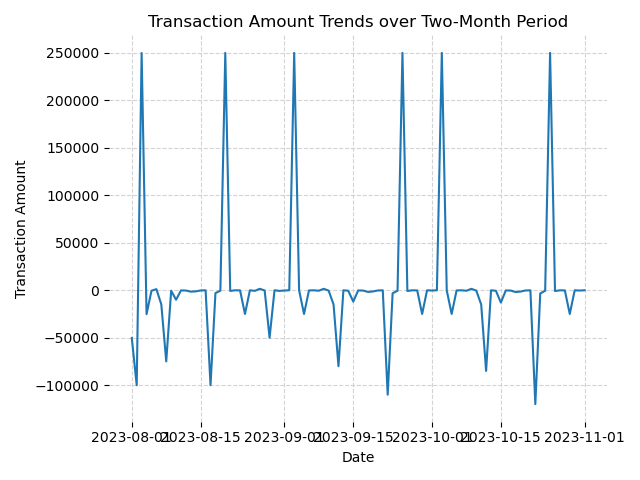

In [12]:
question = "analyze the transaction amount trends over the two-month period."
# viz_specs = "stacked bar chart"
# goal = Goal(question=question, visualization=viz_spces, rationale="")
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)
charts[0]

In [66]:
import json
from utils import clean_code_snippet
from openai_textgen import TextGenerator
from datamodel import LLMResponse, Goal

system_prompt = """
You are a helpful assistant highly skilled in evaluating the quality of a given visualization code by providing a score from 1 (bad) - 10 (good) while providing clear rationale. YOU MUST CONSIDER VISUALIZATION BEST PRACTICES for each evaluation. Specifically, you can carefully evaluate the code across the following dimensions
- bugs (bugs):  are there bugs, logic errors, syntax error or typos? Are there any reasons why the code may fail to compile? How should it be fixed? If ANY bug exists, the bug score MUST be less than 5.
- Data transformation (transformation): Is the data transformed appropriately for the visualization type? E.g., is the dataset appropriated filtered, aggregated, or grouped if needed?
- Goal compliance (compliance): how well the code meets the specified visualization goals?
- Visualization type (type): CONSIDERING BEST PRACTICES, is the visualization type appropriate for the data and intent? Is there a visualization type that would be more effective in conveying insights? If a different visualization type is more appropriate, the score MUST be less than 5.
- Data encoding (encoding): Is the data encoded appropriately for the visualization type?
- aesthetics (aesthetics): Are the aesthetics of the visualization appropriate for the visualization type and the data?

You must provide a score for each of the above dimensions. Assume that data in chart = plot(data) contains a valid dataframe for the dataset. The `plot` function returns a chart (e.g., matplotlib, seaborn etc object).

Your OUTPUT MUST BE A VALID JSON LIST OF OBJECTS in the format:

```[
{ "dimension":  "bugs",  "score": x , "rationale": " .."}, { "dimension":  "transformation",  "score": x, "rationale": " .."}, { "dimension":  "compliance",  "score": x, "rationale": " .."},{ "dimension":  "type",  "score": x, "rationale": " .."}, { "dimension":  "encoding",  "score": x, "rationale": " .."}, { "dimension":  "aesthetics",  "score": x, "rationale": " .."}
]
```
"""


class VizEvaluator(object):
    """Generate visualizations Explanations given some code"""

    def __init__(
        self,
    ) -> None:
        pass

    def generate(self, code: str, goal: Goal, summary: dict,
                 textgen_config: dict, text_gen: TextGenerator, library='matplotlib'):
        """Generate a visualization explanation given some code"""

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "system", "content": f"The dataset summary is : {summary}."},
            {"role": "user",
             "content": f"Generate an evaluation given the goal and code below in {library}. The specified goal is \n\n {goal.question} \n\n and the visualization code is \n\n {code} \n\n. Now, evaluate the code based on the 6 dimensions above. \n. THE SCORE YOU ASSIGN MUST BE MEANINGFUL AND BACKED BY CLEAR RATIONALE. A SCORE OF 1 IS POOR AND A SCORE OF 10 IS VERY GOOD. The structured evaluation is below ."},
        ]

        # print(messages)
        completions:LLMResponse = text_gen.generate(
            messages=messages, config=textgen_config)

        completions = [clean_code_snippet(x.content) for x in completions.text]
        self.completions = completions
        evaluations = []
        for completion in completions:
            try:
                evaluation = json.loads(completion)
                evaluations.append(evaluation)
            except Exception as json_error:
                print("Error parsing evaluation data", completion, str(json_error))
        return evaluations

```python
import matplotlib.pyplot as plt
import pandas as pd

# plan -
def plot(data: pd.DataFrame):
    transaction_amounts = data['Transaction_Amount']
    plt.pie(transaction_amounts, labels=data['Transaction_Description'], autopct='%1.1f%%')
    plt.title('Distribution of Transaction Amounts')
    plt.legend()
    return plt

chart = plot(data) # data already contains the data to be plotted. Always include this line. No additional code beyond this line.
```
****
 Wedge sizes 'x' must be non negative values


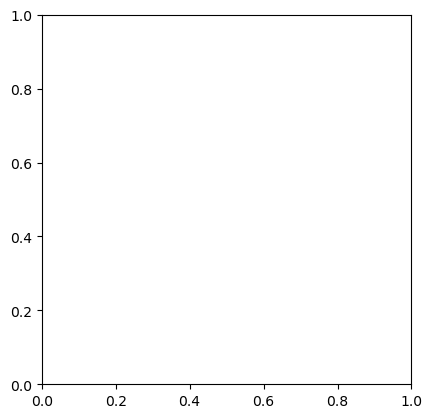

In [51]:
question = "what is the distribution of transaction amounts (pie chart)"
nlviz = m.Manager(text_gen=text_gen, data=df)
charts = nlviz.visualize(summary=data_summary, goal=question, textgen_config=llm_config, return_error=True)

In [59]:
print(charts[0].code)

import matplotlib.pyplot as plt
import pandas as pd

# plan -
def plot(data: pd.DataFrame):
    transaction_amounts = data['Transaction_Amount']
    plt.pie(transaction_amounts, labels=data['Transaction_Description'], autopct='%1.1f%%')
    plt.title('Distribution of Transaction Amounts')
    plt.legend()
    return plt

chart = plot(data)


In [67]:
eval = VizEvaluator()
code = charts[0].code
eval_report = eval.generate(code=code, goal=Goal(question=question, visualization=question ,rationale=""), summary=data_summary, text_gen=text_gen, textgen_config=llm_config)

In [68]:
eval_report

[[{'dimension': 'bugs',
   'score': 8,
   'rationale': "The code does not have any syntax errors or typos. However, there is a potential bug in the data transformation step. The code directly uses the 'Transaction_Amount' column for the pie chart without any aggregation or grouping. This may result in a pie chart with too many slices, making it difficult to interpret."},
  {'dimension': 'transformation',
   'score': 4,
   'rationale': "The data transformation step is not appropriate for the visualization type. The code directly uses the 'Transaction_Amount' column for the pie chart without any aggregation or grouping. To visualize the distribution of transaction amounts, it would be more appropriate to group the amounts into categories (e.g., bins) and then create a pie chart based on the frequency of each category."},
  {'dimension': 'compliance',
   'score': 6,
   'rationale': 'The code partially meets the specified goal of visualizing the distribution of transaction amounts. However